### Leveraging explanation quality for model selection

In this notebook we are going to explore how, using **teex**, we can improve our model selection procedures (following [Jia et al. (2021)](https://dl.acm.org/doi/abs/10.1007/978-3-030-86520-7_43)).

#### 0. Approach

Intuitively, a model that has a good predictive performance and makes decisions based on reasonable evidence is better than one that achieves the same level of accuracy but makes decisions based on circumstantial evidence. So, given an explanation model, we can investigate which evidence a model is basing its decisions on: a quality explanations will be of quality if it's based on reasonable evidence and of low quality otherwise. Then, given two models with similar predictive performance, we should leverage whether or not it is basing its decisions based on good or bad evidence. Given this intuition, we define a model scoring mechanism:

$$ score(f) = \alpha \cdot \text{score}_{acc}(f) + (1 - \alpha)\cdot \text{score}_{\text{explanation}}(f)$$

where $\alpha$ $\in[0, 1]$ is a hyperparameter, $f$ is the model being assessed and $\text{score}_{acc}(f)$ and $\text{score}_{\text{explanation}}(f)$ are accuracy and explanation scores, respectively. All models $f_1, ..., f_n$ will be assigned a score and we will choose based on it. **teex** will help us compute $\text{score}_{\text{explanation}}(f)$.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy

from teex import saliencyMap
from sklearn import metrics
from captum import attr
from torch import optim
from torchvision import models, transforms

#### 1. Getting the data

We are going to work with a subset of the Oxford-IIIT Pet dataset, included in **teex**. It contains roughly 7000 images from 37 categories.

In [22]:
from teex.saliencyMap.data import OxfordIIIT

data = OxfordIIIT()

We have the following classes available

In [23]:
data.classMap

{0: 'cat_Abyssinian',
 1: 'dog_american_bulldog',
 2: 'dog_american_pit_bull_terrier',
 3: 'dog_basset_hound',
 4: 'dog_beagle',
 5: 'cat_Bengal',
 6: 'cat_Birman',
 7: 'cat_Bombay',
 8: 'dog_boxer',
 9: 'cat_British_Shorthair',
 10: 'dog_chihuahua',
 11: 'cat_Egyptian_Mau',
 12: 'dog_english_cocker_spaniel',
 13: 'dog_english_setter',
 14: 'dog_german_shorthaired',
 15: 'dog_great_pyrenees',
 16: 'dog_havanese',
 17: 'dog_japanese_chin',
 18: 'dog_keeshond',
 19: 'dog_leonberger',
 20: 'cat_Maine_Coon',
 21: 'dog_miniature_pinscher',
 22: 'dog_newfoundland',
 23: 'cat_Persian',
 24: 'dog_pomeranian',
 25: 'dog_pug',
 26: 'cat_Ragdoll',
 27: 'cat_Russian_Blue',
 28: 'dog_saint_bernard',
 29: 'dog_samoyed',
 30: 'dog_scottish_terrier',
 31: 'dog_shiba_inu',
 32: 'cat_Siamese',
 33: 'cat_Sphynx',
 34: 'dog_staffordshire_bull_terrier',
 35: 'dog_wheaten_terrier',
 36: 'dog_yorkshire_terrier'}

We are going to work in a binary setting, so let us choose two cat targets.

In [24]:
imSi, labSi, exSi = data.get_class_observations(32) # Siamese cats
imSp, labSp, exSp = data.get_class_observations(33) # Sphynx cats

(-0.5, 499.5, 374.5, -0.5)

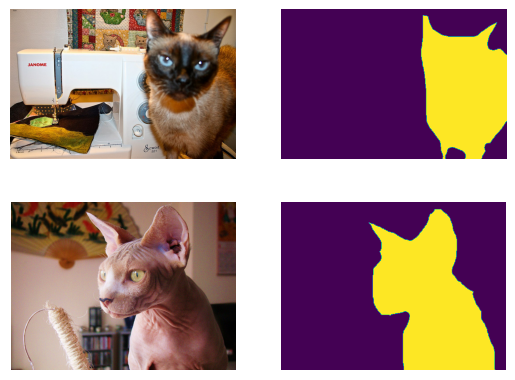

In [25]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np.array(imSi[5]))
axarr[0,0].axis("off")
axarr[0,1].imshow(np.array(exSi[5]))
axarr[0,1].axis("off")
axarr[1,0].imshow(np.array(imSp[4]))
axarr[1,0].axis("off")
axarr[1,1].imshow(np.array(exSp[4]))
axarr[1,1].axis("off")

#### 2. Declaring our classifiers

We create a common model class that will help us perform the experiments and implement its logic. We use teex in the evaluation functions.

In [28]:
class Model:
    """ Our Model class. Training will be performed with 50 epochs,  """
    
    def __init__(self, modelName: str, model: torch.nn.Module, 
                 input_size: int, random_state: int = 888) -> None:
        self.modelName = modelName
        self.model = model
        self.random_state = random_state
        self.input_size = input_size
        
        self._trained = False
        self._valid_explainers = ("ggac", "sal", "gshap", "bp")
        self._latent_explainers = {
            "ggac": attr.GuidedGradCam,
            "sal": attr.Saliency,
            "gshap": attr.GradientShap, 
            "bp": attr.GuidedBackprop
        }
        self._lr = 0.001
        self._n_epochs = 50
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._optim_momentum = 0.9
        self._optimizer = optim.SGD(self.model.parameters(), lr=self._lr, momentum=self._optim_momentum)
        self._criterion = torch.nn.CrossEntropyLoss()
        
    def train(self, dataloaders: dict) -> None:
        
        if self._check_is_trained():
            raise Exception("Model is already trained!")

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        for epoch in range(self._n_epochs):
            print('Epoch {}{}'.format(epoch, self._n_epochs - 1))
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self._device)
                    labels = labels.to(self._device)

                    # zero the parameter gradients
                    self._optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            self._optimizer.step()

                    running_loss += loss.item() / inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print(self.modelName + ' {} Loss {.4f} Acc {.4f}'.format(phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())

        self.model.load_state_dict(best_model_wts)
        self._trained = True
    
    def get_explanations(self, X, method: str = "ggcam", expParams: dict = None) -> np.ndarray:
        if self._check_is_trained() and self._check_explainer(method):
            explainer = self._get_explainer(method, **expParams)
            pred_labels = self.model(X)
            exps = explainer.attribute(X, pred_labels)
            return exps
        
    def get_predictions(self, X):
        if self._check_is_trained():
            return self.model(X)
    
    def compute_acc(self, gtY, y) -> float:
        scores = metrics.accuracy_score(y, gtY)
        return np.mean(scores)
    
    def compute_exp_score(self, gtExps, predExps) -> float:
        scores = saliencyMap.eval.saliency_map_scores(gtExps, predExps, metrics="auc")
        return scores
    
    def compute_total_score(self, 
                            y: np.ndarray, 
                            gtY: np.ndarray, 
                            exps: np.ndarray, 
                            gtExps: np.ndarray,
                            alpha: float) -> float:
        
        return alpha * self.compute_acc(gtY, y) + (1 - alpha) * self.compute_exp_score(gtExps, exps)
    
    def _check_is_trained(self) -> bool:
        if not self.trained:
            raise Exception("Model is not trained yet!")
        else:
            return True
        
    def _check_explainer(self, exp: str) -> bool:
        if exp not in self._valid_explainers():
            raise ValueError(f"Explainer {exp} is not valid. ({self._valid_explainers})")
        else:
            return True
        
    def _get_explainer(self, exp: str, **kwargs) -> bool:
        if kwargs is not None:
            explainer = self._latent_explainers[exp](self.model, kwargs)
        else:
            explainer = self._latent_explainers[exp](self.model)
            
        return explainer

We then get 2 pre-trained models, modify them to our usecase and initialize them.

In [33]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

# SqueezeNet
sqz = models.squeezenet1_0(weights="DEFAULT")
set_parameter_requires_grad(sqz)
sqz.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
sqz.num_classes = 2
input_size = 224

squeezeNet = Model("SqueezeNet", sqz, input_size)

#### 3. Preparing our data

Now, we are going to create the data splits and transform the observations
to the model's required input size.

In [59]:
import random
random.seed(888)

def transform(images, input_size, exps=False):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor()
    ])
    if not exps:
        norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        d = [norm(transform(im)) for im in images]
    else:
        d = [transform(im) for im in images]
    return torch.stack(d, axis=0)

indexes = random.sample(list(range(len(imSi) + len(imSp))), len(imSi) + len(imSp))
ims, labs, exps = (imSi + imSp, labSi + labSp, exSi + exSp)

ims = transform([ims[idx] for idx in indexes], input_size)
labs = torch.FloatTensor([labs[idx] for idx in indexes])
exps = transform([exps[idx] for idx in indexes], input_size, exps=True).numpy()

In [ ]:
# WIP...